In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import umap.umap_ as umap
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from sklearn.preprocessing import StandardScaler

In [2]:
SR = 22050
DURATION = 1
N_BINS_CQT = 60
BINS_PER_OCTAVE_CQT = 12
HOP_LENGTH_CQT = 512

expected_frames = int(np.ceil(DURATION * SR / HOP_LENGTH_CQT))
FIXED_SHAPE_CQT = (N_BINS_CQT, expected_frames)

In [3]:
def audio_to_cqt(audio_path):
    try:
        # Load with fixed duration (pad/trim as needed)
        y, sr = librosa.load(audio_path, sr=SR, duration=DURATION)

        # Padding if the loaded audio is shorter than the desired duration
        if len(y) < SR * DURATION:
            y = np.pad(y, (0, max(0, int(SR * DURATION) - len(y))))

        # Generate CQT spectrogram
        C = librosa.cqt(y=y, sr=sr, n_bins=N_BINS_CQT, bins_per_octave=BINS_PER_OCTAVE_CQT, hop_length=HOP_LENGTH_CQT)
        C_db = librosa.amplitude_to_db(np.abs(C), ref=np.max)

        # Ensure consistent shape
        # The number of bins (rows) from CQT should naturally be N_BINS_CQT,
        # so we mainly focus on the number of columns (time frames).
        if C_db.shape[1] > FIXED_SHAPE_CQT[1]:
            C_db = C_db[:, :FIXED_SHAPE_CQT[1]] # Truncate columns
        elif C_db.shape[1] < FIXED_SHAPE_CQT[1]:
            C_db = np.pad(C_db, ((0,0), (0,FIXED_SHAPE_CQT[1]-C_db.shape[1])), mode='constant') # Pad columns

        # Sanity check for the number of frequency bins (should be N_BINS_CQT)
        if C_db.shape[0] != FIXED_SHAPE_CQT[0]:
             # This case is less common for CQT if n_bins is correctly set,
             # but keeping a robust check.
             print(f"Warning: CQT bins mismatch. Expected {FIXED_SHAPE_CQT[0]}, got {C_db.shape[0]}.")
             # You might need a more sophisticated padding/truncation here if this occurs often.
             # For now, let's just make sure it's consistent.
             if C_db.shape[0] < FIXED_SHAPE_CQT[0]:
                 C_db = np.pad(C_db, ((0, FIXED_SHAPE_CQT[0] - C_db.shape[0]), (0, 0)), mode='constant')
             else:
                 C_db = C_db[:FIXED_SHAPE_CQT[0], :]


        return C_db.flatten()
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None

In [4]:
wavs = list(Path("mswc_microset/mswc_microset/en/clips").rglob("*.opus"))
print(f"Found {len(wavs)} files")

keyword_dict = defaultdict(list)
for wav in wavs:
    label = wav.parts[-2]
    if len(keyword_dict[label]) < 15:
        keyword_dict[label].append(wav)

Found 96099 files


In [5]:
cqt = []
valid_labels = []
for label, paths in keyword_dict.items():
    for path in paths:
        spec = audio_to_cqt(str(path))
        if spec is not None:
            cqt.append(spec)
            valid_labels.append(label)

In [6]:
cqts = np.stack(cqt)  # Uses stack instead of array for safety
print(f"Final array shape: {cqts.shape}")

Final array shape: (465, 2640)


In [7]:
# Standardize and project
scaler = StandardScaler()
scaled = scaler.fit_transform(cqts)
embedding = umap.UMAP(random_state=42).fit_transform(scaled)

C:\Users\tyree\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tyree\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [8]:
df = pd.DataFrame({
    'x': embedding[:, 0],  # UMAP's first dimension
    'y': embedding[:, 1],  # UMAP's second dimension
    'keyword': valid_labels # Your categorical labels
})

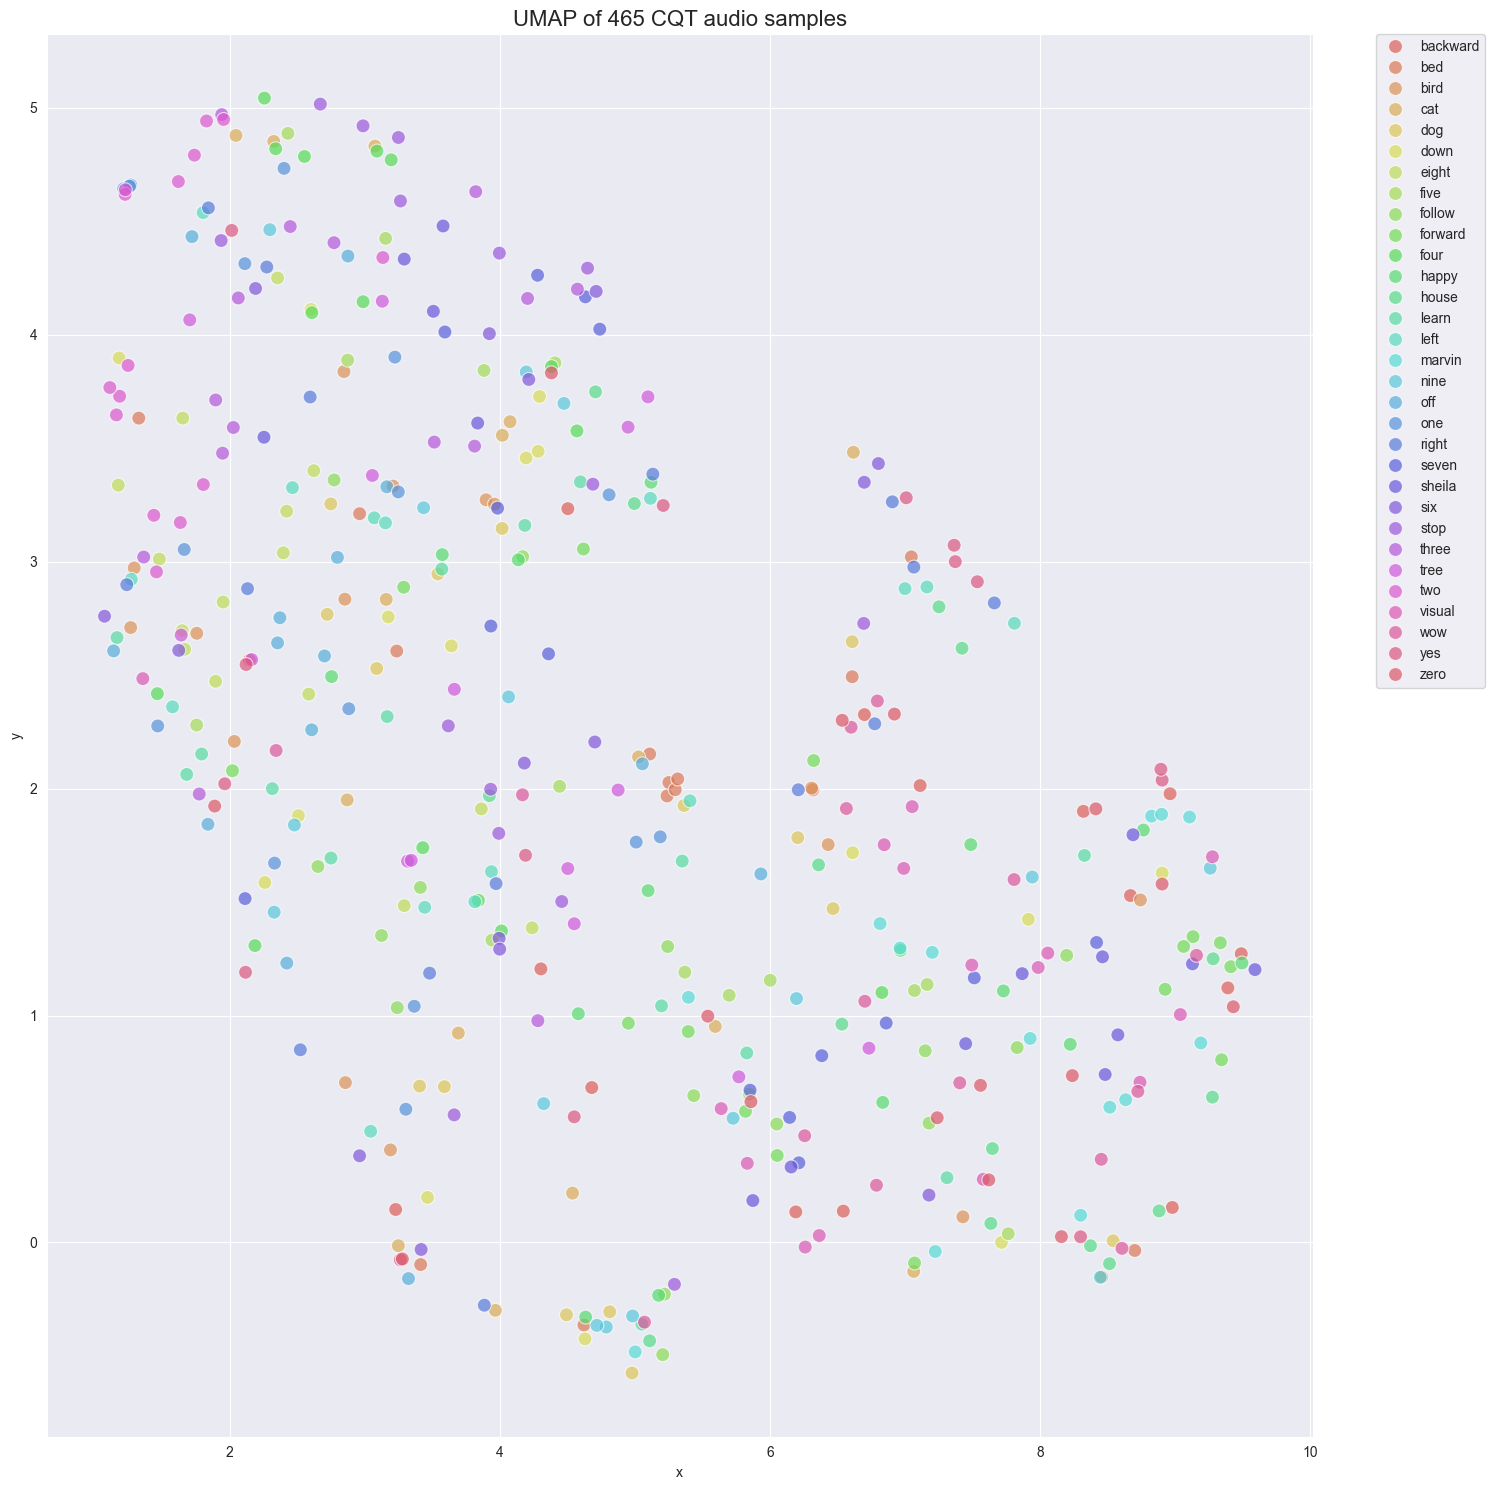

In [9]:
# Set up the plot
plt.figure(figsize=(15, 15)) # Adjust figure size for better readability

# Create the scatter plot using Seaborn
sns.scatterplot(
    x='x',
    y='y',
    hue='keyword',  # Color points by their 'keyword' label
    data=df,
    palette=sns.color_palette('hls', len(set(valid_labels))), # Generate distinct colors
    s=100,  # Size of the markers
    alpha=0.7 # Transparency of the markers
)

# Add a title to your plot
plt.title(f"UMAP of {len(valid_labels)} CQT audio samples", fontsize=16)

# Place the legend outside the plot area to prevent overlap
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Adjust plot layout to prevent labels/legend from being cut off
plt.tight_layout()

# Display the plot
plt.show()

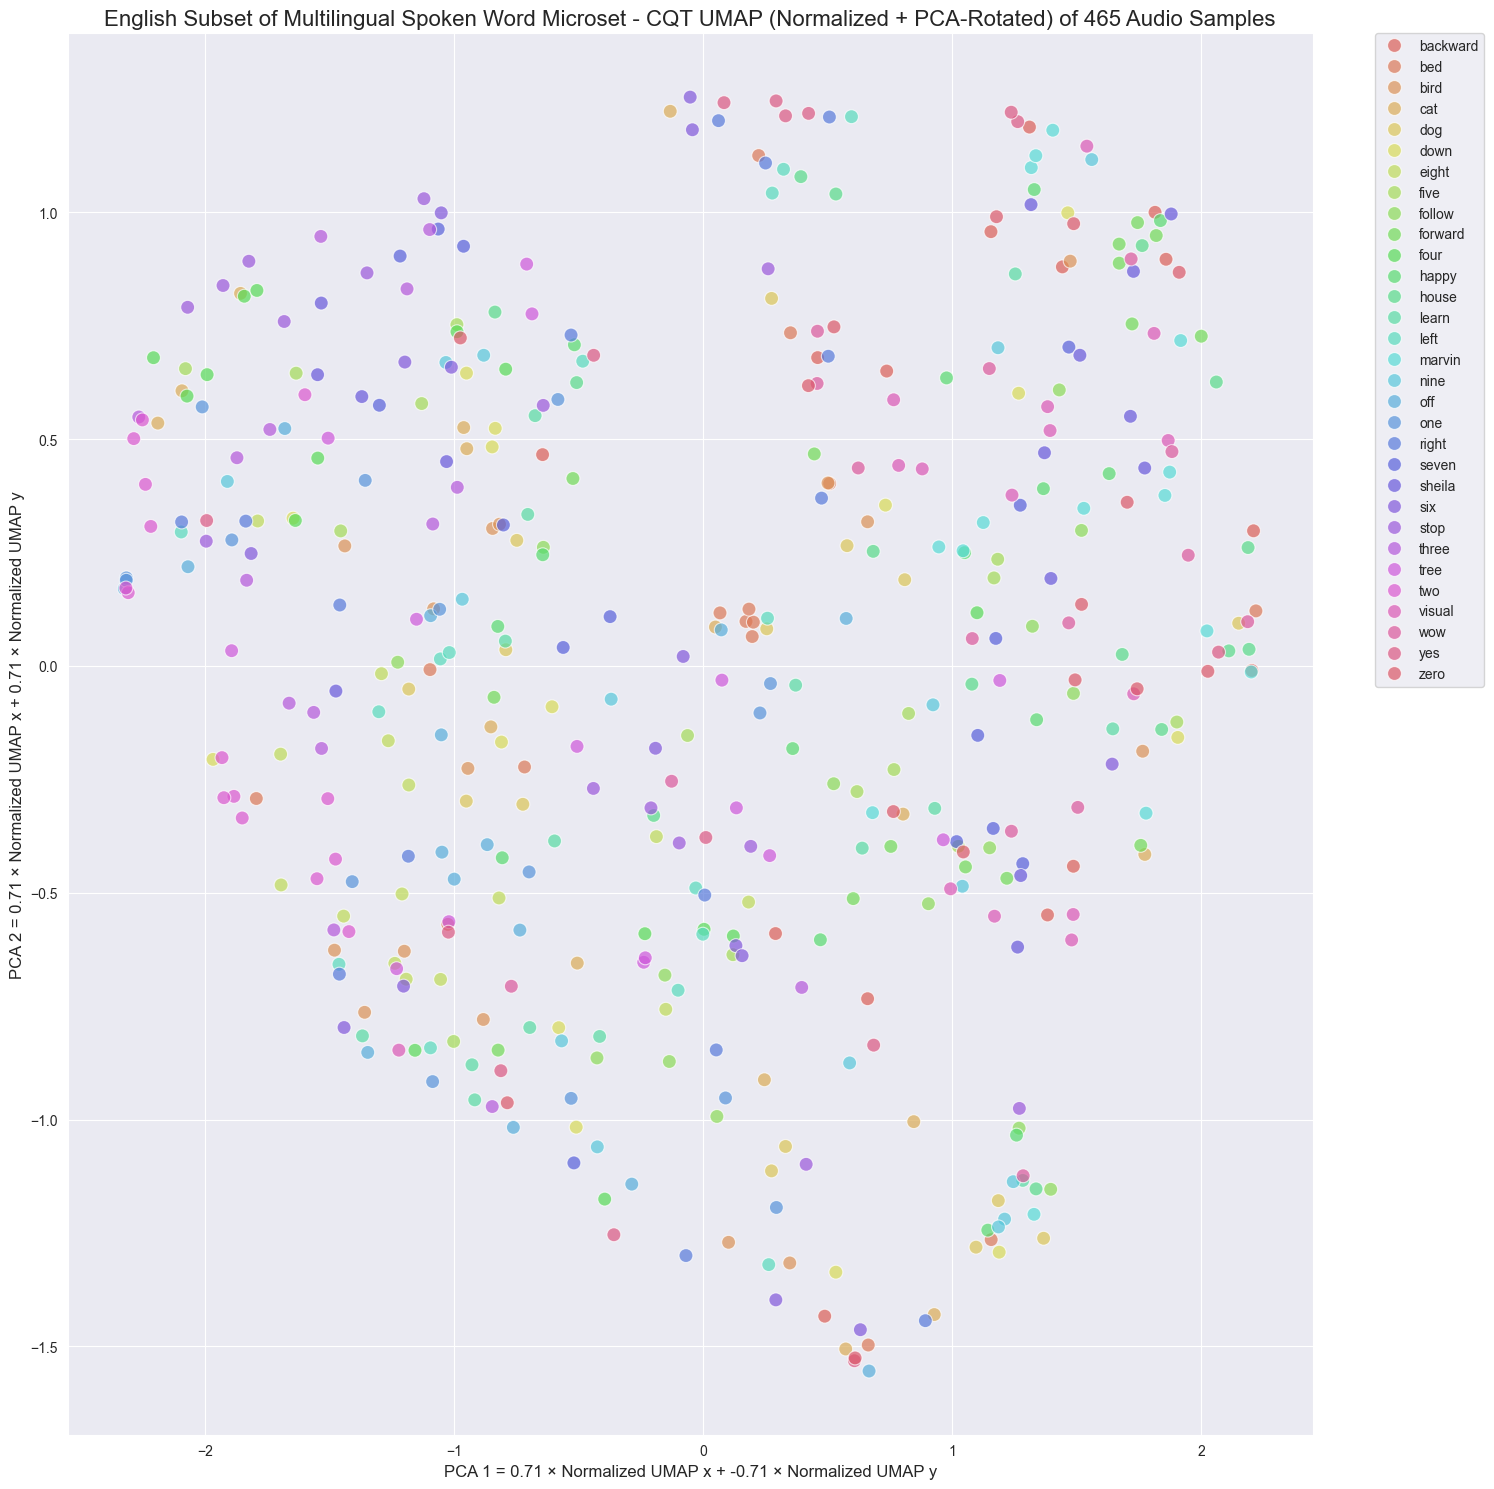

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'embedding' (your 2D UMAP output) and 'valid_labels' are already defined from previous steps.

# Normalize the UMAP embedding
# This scales each UMAP dimension to have zero mean and unit variance.
scaler = StandardScaler()
normalized_embedding = scaler.fit_transform(embedding)

# Apply PCA to rotate the normalized UMAP embedding
# PCA is now applied to the scaled UMAP output.
pca = PCA(n_components=2)
rotated_embedding = pca.fit_transform(normalized_embedding)

# Get PCA component coefficients
# These coefficients relate the new PCA axes back to the *normalized* UMAP dimensions.
pc1 = pca.components_[0]
pc2 = pca.components_[1]

# Format axis labels
# The labels now explicitly state that the PCA components are derived from
# the *normalized* UMAP x and y.
x_label = f'PCA 1 = {pc1[0]:.2f} × Normalized UMAP x + {pc1[1]:.2f} × Normalized UMAP y'
y_label = f'PCA 2 = {pc2[0]:.2f} × Normalized UMAP x + {pc2[1]:.2f} × Normalized UMAP y'

# Create DataFrame for plotting
rotated_df = pd.DataFrame({
    'x': rotated_embedding[:, 0],
    'y': rotated_embedding[:, 1],
    'keyword': valid_labels
})

# Plot
plt.figure(figsize=(15, 15))
sns.scatterplot(
    x='x', y='y',
    hue='keyword',
    data=rotated_df,
    palette=sns.color_palette('hls', len(set(valid_labels))),
    s=100,
    alpha=0.7
)

# Apply the custom PCA-derived axis labels
plt.xlabel(x_label, fontsize=12)
plt.ylabel(y_label, fontsize=12)

# Update the title to reflect both normalization and PCA rotation
plt.title(f"English Subset of Multilingual Spoken Word Microset - CQT UMAP (Normalized + PCA-Rotated) of {len(valid_labels)} Audio Samples", fontsize=16)

# Place the legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Adjust plot layout
plt.tight_layout()

# Display the plot
plt.show()

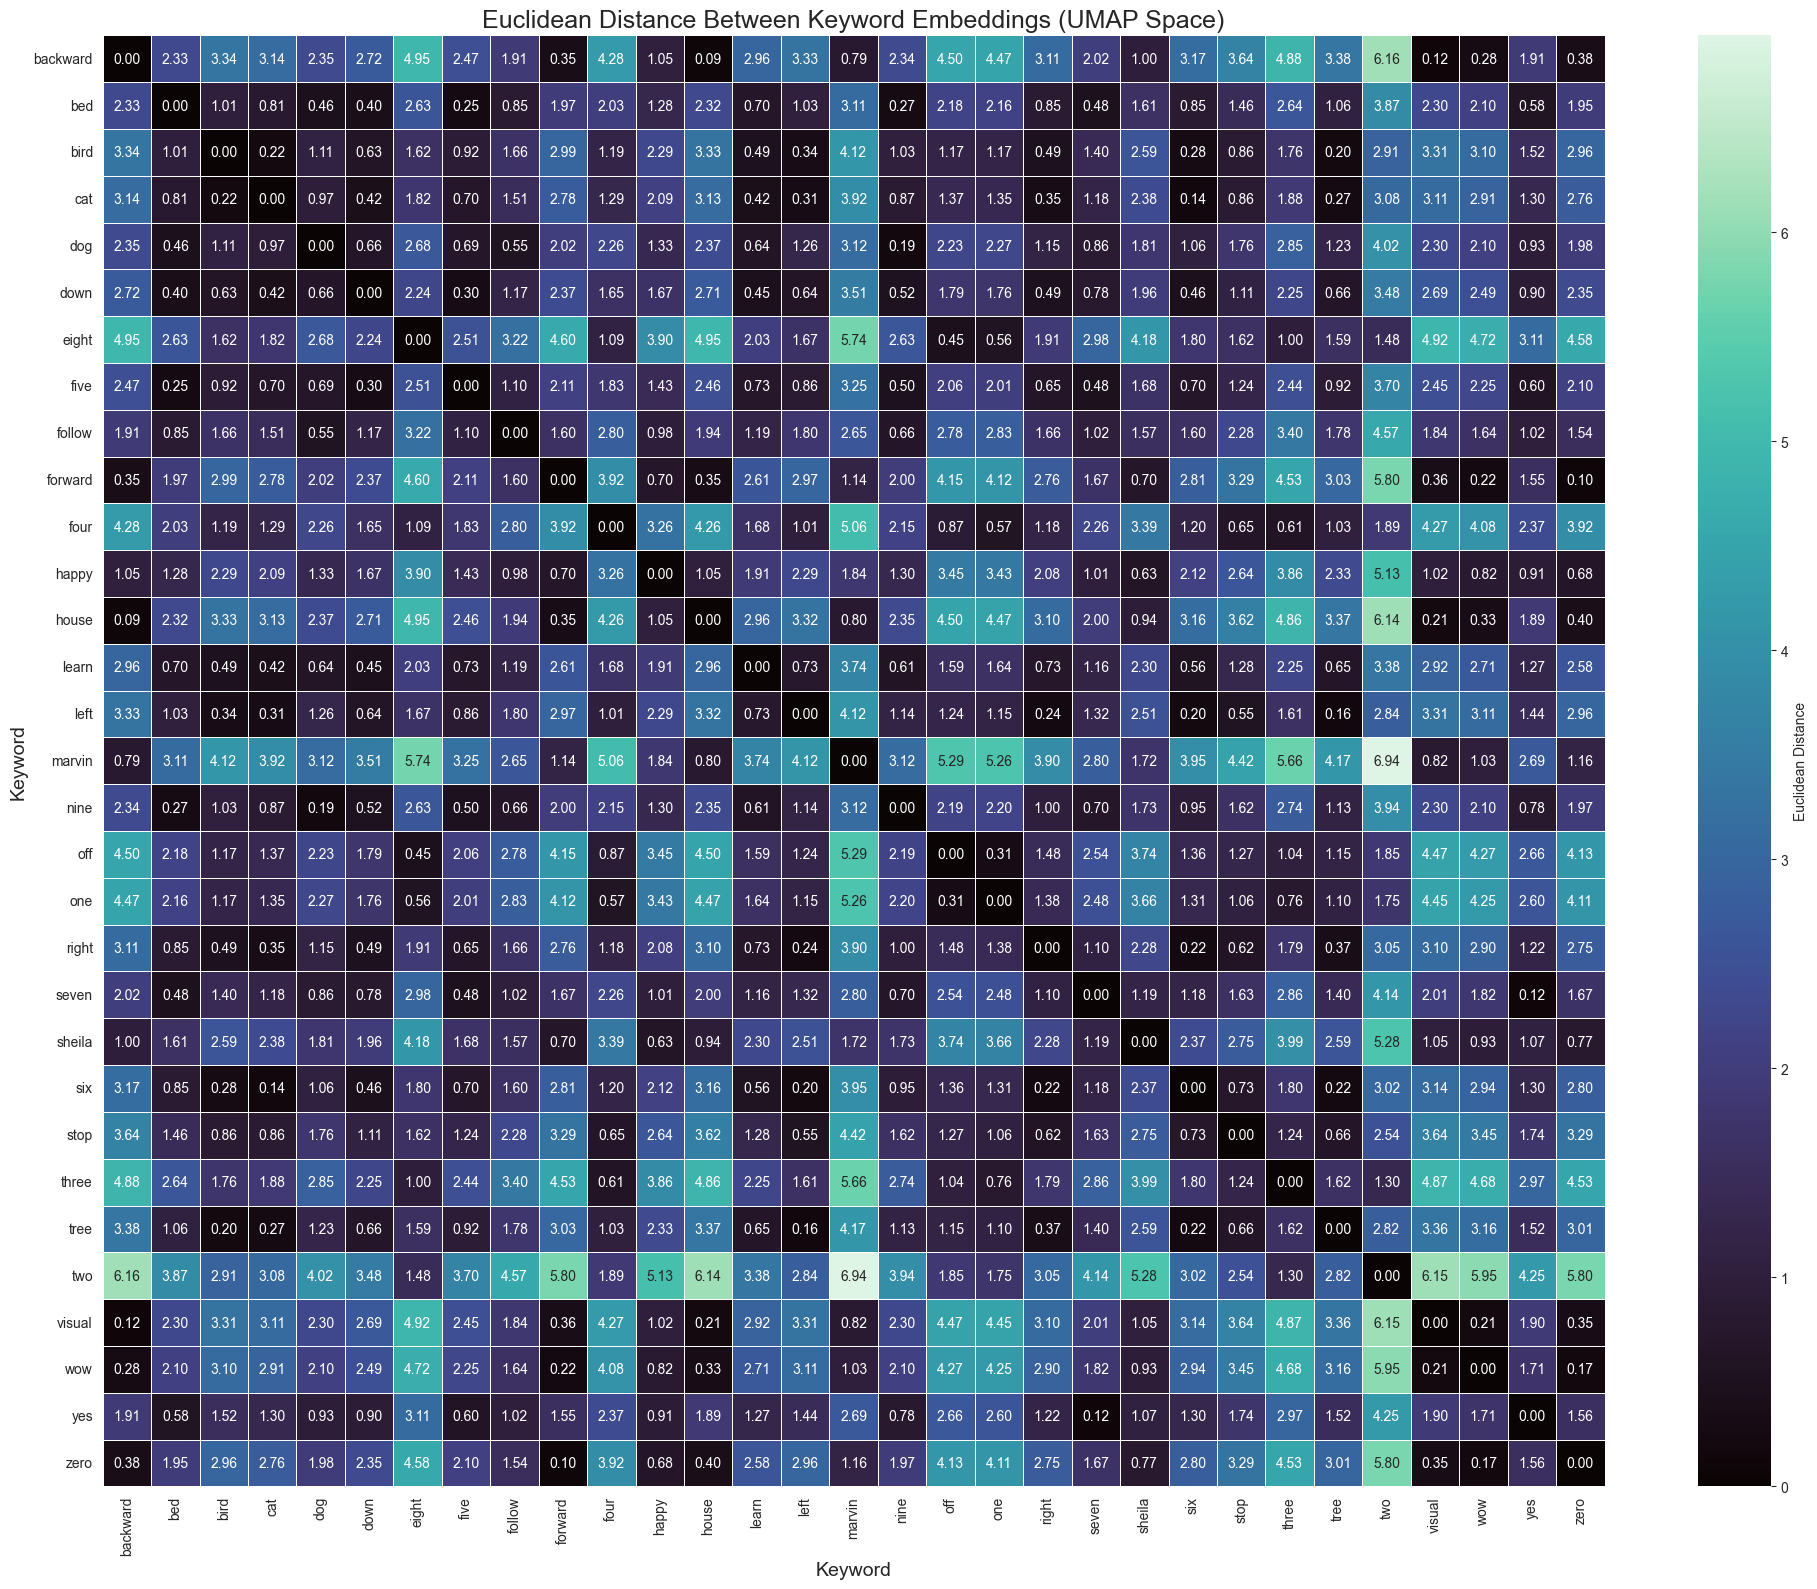

In [11]:
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd # Although not strictly needed for this specific plotting, it's good practice
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'embedding' (your UMAP output) and 'valid_labels' are available from previous steps.

# Get unique labels and initialize a dictionary to store vectors per label
unique_labels = sorted(list(set(valid_labels))) # Convert to list for sorting
label_to_vectors = {label: [] for label in unique_labels}

# Populate the dictionary with UMAP vectors for each corresponding label
for label, vec in zip(valid_labels, embedding):
    label_to_vectors[label].append(vec)

# Calculate the mean embedding vector for each label
# This creates a "centroid" for each keyword's cluster in the UMAP space.
label_means = {label: np.mean(vectors, axis=0) for label, vectors in label_to_vectors.items()}

# Prepare the mean vectors for distance calculation
# Order them consistently with unique_labels for correct heatmap labels.
mean_matrix = np.array([label_means[label] for label in unique_labels])

# Calculate pairwise Euclidean distances between the mean vectors
# cdist is efficient for computing distances between all pairs of vectors in two arrays.
distance_matrix = cdist(mean_matrix, mean_matrix, metric='euclidean')

# Plotting the heatmap
plt.figure(figsize=(20, 16)) # Adjust figure size for better readability with many keywords
sns.heatmap(
    distance_matrix,
    xticklabels=unique_labels, # Labels for the X-axis (keywords)
    yticklabels=unique_labels, # Labels for the Y-axis (keywords)
    cmap="mako",               # Color map (e.g., "mako" for dark to light, "viridis", "plasma")
    annot=True,                # Annotate cells with the distance values
    fmt=".2f",                 # Format annotations to two decimal places
    linewidths=.5,             # Add lines between cells for better separation
    cbar_kws={'label': 'Euclidean Distance'} # Label the color bar
)

plt.title("Euclidean Distance Between Keyword Embeddings (UMAP Space)", fontsize=18)
plt.xlabel("Keyword", fontsize=14)
plt.ylabel("Keyword", fontsize=14)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

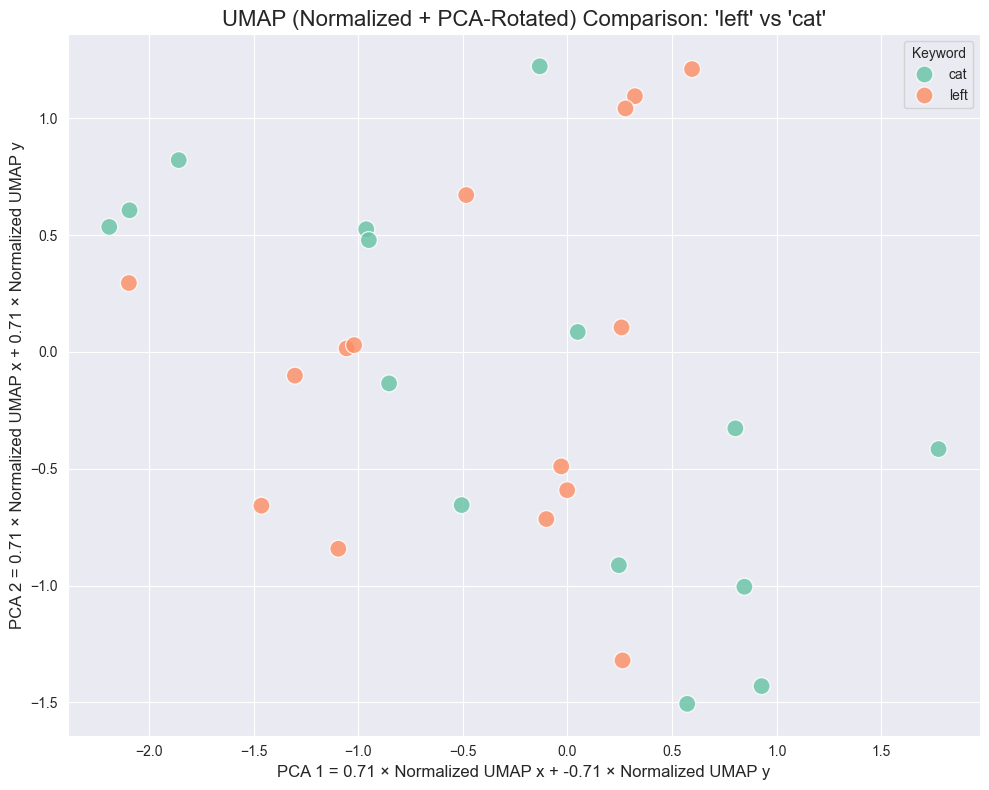

In [12]:
target_keywords = ['left', 'cat']

# Create a subset of the DataFrame containing only the data for the target keywords.
subset_df = rotated_df[rotated_df['keyword'].isin(target_keywords)]

# Plot the subset with distinct colors for each chosen keyword.
plt.figure(figsize=(10, 8)) # Set a suitable figure size for better focus
sns.scatterplot(
    x='x',
    y='y',
    hue='keyword',  # Differentiate chosen keywords by color
    data=subset_df,
    s=150,          # Slightly larger points for better visibility
    alpha=0.8,
    palette='Set2'  # A different palette to easily distinguish two groups
)

# Add a descriptive title to the plot.
plt.title(f"UMAP (Normalized + PCA-Rotated) Comparison: '{target_keywords[0]}' vs '{target_keywords[1]}'", fontsize=16)

# Apply the custom PCA-derived axis labels for context.
plt.xlabel(x_label, fontsize=12)
plt.ylabel(y_label, fontsize=12)

# Display the legend to identify which color corresponds to which keyword.
plt.legend(title="Keyword")

# Adjust the plot layout to ensure everything fits.
plt.tight_layout()

# Show the plot.
plt.show()

Silhouette Score for KMeans on 'left' vs 'cat': 0.4000


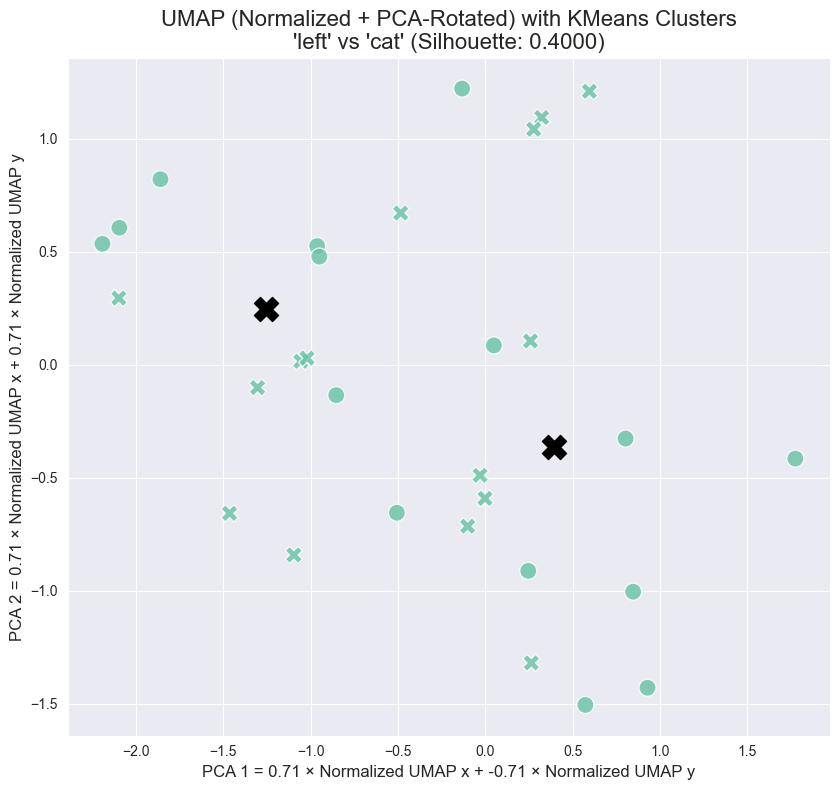

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter

# Filter dataframe for target keywords
# Using .copy() to avoid SettingWithCopyWarning
subset_df = rotated_df[rotated_df['keyword'].isin(target_keywords)].copy()

# Prepare data for KMeans (only x, y coordinates from the rotated UMAP embedding)
X = subset_df[['x', 'y']].values

# Run KMeans with 2 clusters (since we're comparing 2 specific words)
# random_state ensures reproducibility of the clustering results
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto') # n_init='auto' is a good default for recent KMeans
subset_df['cluster'] = kmeans.fit_predict(X)
labels = kmeans.labels_ # These are the cluster assignments for each point

# Calculate the Silhouette Score
# The Silhouette Score ranges from -1 to 1.
# Closer to 1 means samples are well-clustered, closer to -1 means they are mis-clustered.
sil_score = silhouette_score(X, labels)
print(f"Silhouette Score for KMeans on '{target_keywords[0]}' vs '{target_keywords[1]}': {sil_score:.4f}")

# Map each cluster ID back to the keyword that is most dominant in that cluster
cluster_to_keyword = {}
for cluster_id in subset_df['cluster'].unique():
    keywords_in_cluster = subset_df[subset_df['cluster'] == cluster_id]['keyword']
    # Find the most common keyword in this cluster
    most_common_keyword = Counter(keywords_in_cluster).most_common(1)[0][0]
    cluster_to_keyword[cluster_id] = most_common_keyword

# Add a 'predicted_keyword' column to the DataFrame based on cluster assignment
subset_df['predicted_keyword'] = subset_df['cluster'].map(cluster_to_keyword)

# Now, plot the results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='x',
    y='y',
    hue='predicted_keyword', # Color based on the KMeans-assigned "predicted keyword"
    style='keyword',         # Shape based on the original "true" keyword
    data=subset_df,
    palette='Set2',          # A nice palette for distinct categories
    s=150,                   # Point size
    alpha=0.8,
    legend='full'            # Ensure all legend elements are shown
)

# Plot the cluster centers (centroids)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=300, marker='X', label='Cluster Centers', zorder=5) # zorder to ensure centers are on top

# Set plot title and labels
plt.title(f"UMAP (Normalized + PCA-Rotated) with KMeans Clusters\n'{target_keywords[0]}' vs '{target_keywords[1]}' (Silhouette: {sil_score:.4f})", fontsize=16)
plt.xlabel(x_label, fontsize=12)
plt.ylabel(y_label, fontsize=12)

# Adjust legend to show both hue (predicted) and style (true) information clearly
# Seaborn often handles this automatically with 'legend='full'', but explicit control can help
handles, labels = plt.gca().get_legend_handles_labels()

# Separate handles and labels for 'hue' and 'style'
hue_labels = [l for l in labels if l in target_keywords]
hue_handles = [h for h, l in zip(handles, labels) if l in target_keywords]

style_labels = [l for l in labels if l not in target_keywords and l != 'Cluster Centers'] # Exclude centers for style legend
style_handles = [h for h, l in zip(handles, labels) if l not in target_keywords and l != 'Cluster Centers']

center_handle = [h for h, l in zip(handles, labels) if l == 'Cluster Centers'][0]
center_label = 'Cluster Centers'

# Create custom legends
# For the hue legend (predicted keywords)
legend1 = plt.legend(hue_handles, hue_labels, title="Predicted Keyword", loc='upper left', bbox_to_anchor=(1.05, 1))
plt.gca().add_artist(legend1) # Add the first legend to the figure

# For the style legend (true keywords)
legend2 = plt.legend(style_handles, style_labels, title="True Keyword", loc='upper left', bbox_to_anchor=(1.05, 0.75))
plt.gca().add_artist(legend2)

# For the cluster centers legend
legend3 = plt.legend([center_handle], [center_label], loc='upper left', bbox_to_anchor=(1.05, 0.6))
plt.gca().add_artist(legend3)


plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legends
plt.show()

In [14]:
results = []

# Loop over all unique pairs of keywords
for i in range(len(unique_labels)):
    for j in range(i + 1, len(unique_labels)):
        k1, k2 = unique_labels[i], unique_labels[j]

        # Filter for these two keywords
        subset_df = rotated_df[rotated_df['keyword'].isin([k1, k2])].copy()
        X = subset_df[['x', 'y']].values

        # Skip if not enough samples
        if len(X) < 4:
            continue

        # KMeans
        kmeans = KMeans(n_clusters=2, random_state=42)
        labels = kmeans.fit_predict(X)

        # Silhouette Score
        try:
            sil_score = silhouette_score(X, labels)
        except ValueError:
            sil_score = np.nan

        # Euclidean distance between cluster means in original UMAP space
        vec1 = np.mean([vec for lbl, vec in zip(valid_labels, embedding) if lbl == k1], axis=0)
        vec2 = np.mean([vec for lbl, vec in zip(valid_labels, embedding) if lbl == k2], axis=0)
        dist = np.linalg.norm(vec1 - vec2)

        results.append({
            'keyword_1': k1,
            'keyword_2': k2,
            'silhouette_score': sil_score,
            'euclidean_distance': dist
        })

# Create DataFrame
results_df = pd.DataFrame(results)

# Drop NaNs
results_df = results_df.dropna()

In [15]:
results_df

,keyword_1,keyword_2,silhouette_score,euclidean_distance
0,backward,bed,0.379035,2.326205
1,backward,bird,0.502496,3.336885
2,backward,cat,0.449468,3.136870
3,backward,dog,0.351262,2.353183
4,backward,down,0.465340,2.718520
...,...,...,...,...
460,visual,yes,0.385794,1.903315
461,visual,zero,0.595987,0.348775
462,wow,yes,0.290799,1.714502
463,wow,zero,0.446003,0.166933


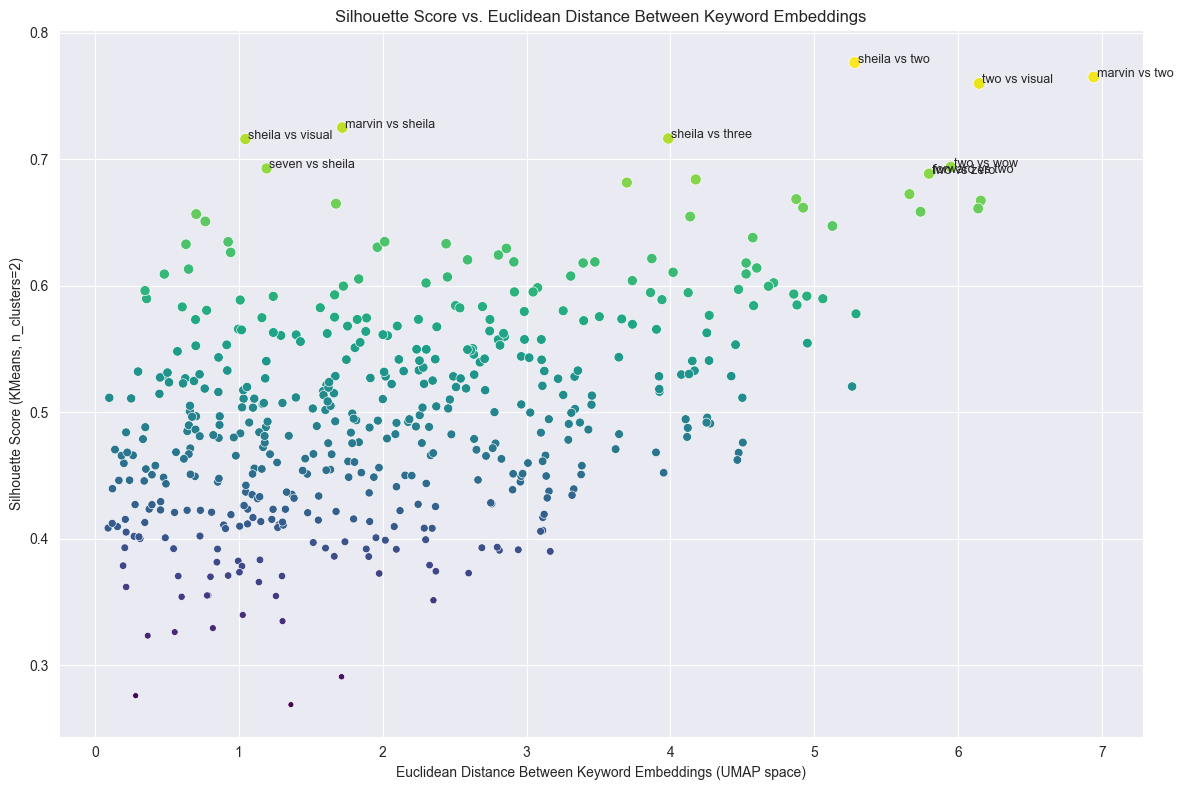

In [16]:
# Scatter plot of silhouette score vs. Euclidean distance
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='euclidean_distance',
    y='silhouette_score',
    hue='silhouette_score',
    size='silhouette_score',
    data=results_df,
    palette='viridis',
    legend=False
)

for _, row in results_df.nlargest(10, 'silhouette_score').iterrows():
    plt.text(row['euclidean_distance'] + 0.02, row['silhouette_score'],
             f"{row['keyword_1']} vs {row['keyword_2']}", fontsize=9)

plt.title("Silhouette Score vs. Euclidean Distance Between Keyword Embeddings")
plt.xlabel("Euclidean Distance Between Keyword Embeddings (UMAP space)")
plt.ylabel("Silhouette Score (KMeans, n_clusters=2)")
plt.tight_layout()
plt.show()

Pearson correlation (embedding distance vs silhouette): r = 0.590, p = 5.418e-45


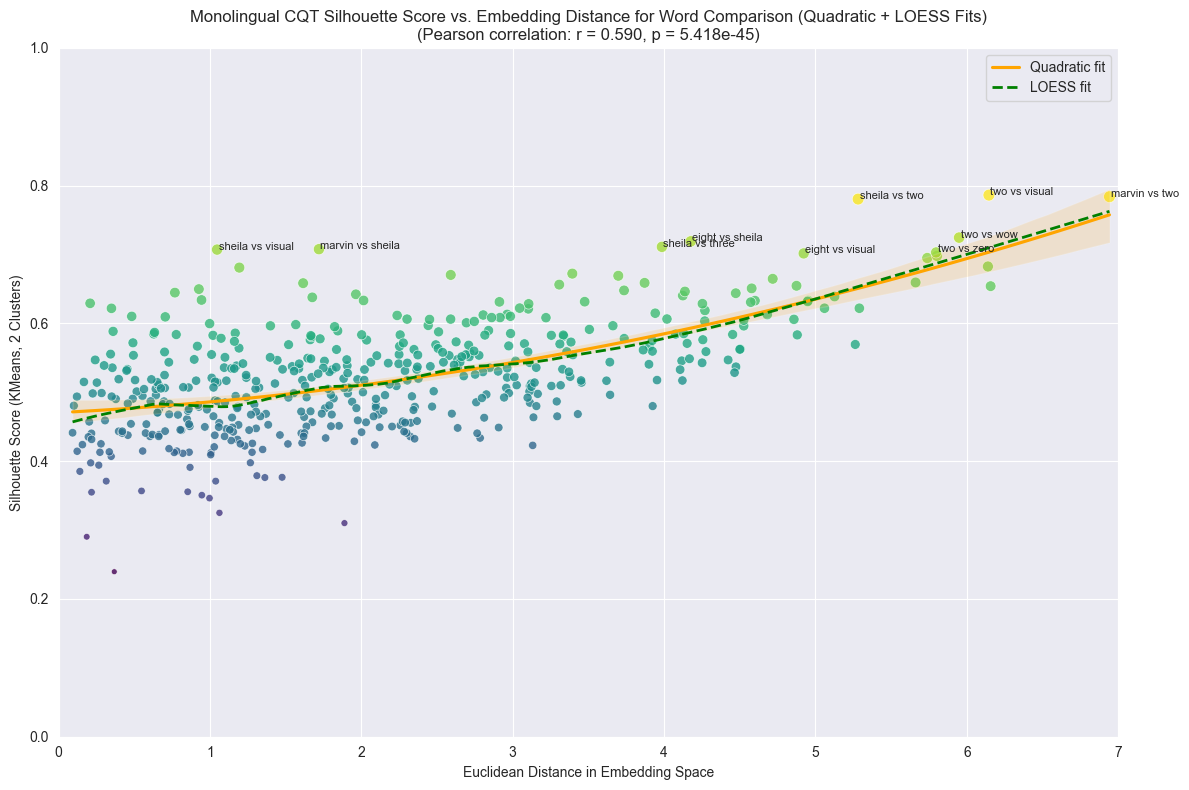

In [17]:
from scipy.stats import pearsonr
import itertools
import statsmodels.api as sm

unique_labels = sorted(set(valid_labels))
label_to_vectors = {label: [] for label in unique_labels}
for label, vec in zip(valid_labels, embedding):
    label_to_vectors[label].append(vec)

# Step 2: Precompute mean embeddings (embedding space) and UMAP means (rotated_df)
label_means_embed = {label: np.mean(vecs, axis=0) for label, vecs in label_to_vectors.items()}
label_means_umap = rotated_df.groupby("keyword")[["x", "y"]].mean().to_dict(orient="index")

# Step 3: Evaluate silhouette and distances
results = []
for kw1, kw2 in itertools.combinations(unique_labels, 2):
    vecs_kw1 = label_to_vectors[kw1]
    vecs_kw2 = label_to_vectors[kw2]
    vectors = np.array(vecs_kw1 + vecs_kw2)
    labels = [kw1] * len(vecs_kw1) + [kw2] * len(vecs_kw2)

    if len(set(labels)) < 2 or len(vectors) < 4:
        continue

    kmeans = KMeans(n_clusters=2, random_state=42)
    cluster_labels = kmeans.fit_predict(vectors)

    try:
        sil_score = silhouette_score(vectors, cluster_labels)
    except ValueError:
        sil_score = np.nan

    # Euclidean distance in full embedding space
    embed_dist = np.linalg.norm(label_means_embed[kw1] - label_means_embed[kw2])

    # Euclidean distance in UMAP space
    if kw1 in label_means_umap and kw2 in label_means_umap:
        umap_vec1 = np.array([label_means_umap[kw1]["x"], label_means_umap[kw1]["y"]])
        umap_vec2 = np.array([label_means_umap[kw2]["x"], label_means_umap[kw2]["y"]])
        umap_dist = np.linalg.norm(umap_vec1 - umap_vec2)
    else:
        umap_dist = np.nan

    results.append({
        'keyword_1': kw1,
        'keyword_2': kw2,
        'silhouette_score': sil_score,
        'embedding_distance': embed_dist,
        'umap_distance': umap_dist
    })

# Step 4: Create DataFrame and clean
results_df = pd.DataFrame(results)
results_df.dropna(inplace=True)

# Step 5: Correlation
r, p = pearsonr(results_df["embedding_distance"], results_df["silhouette_score"])
print(f"Pearson correlation (embedding distance vs silhouette): r = {r:.3f}, p = {p:.3e}")

plt.figure(figsize=(12, 8))

# Scatter plot (unchanged)
sns.scatterplot(
    data=results_df,
    x="embedding_distance",
    y="silhouette_score",
    hue="silhouette_score",
    size="silhouette_score",
    palette="viridis",
    legend=False,
    alpha=0.8
)

# Quadratic fit (unchanged)
sns.regplot(
    data=results_df,
    x="embedding_distance",
    y="silhouette_score",
    scatter=False,
    color="orange",
    order=2,
    ci=95,
    label='Quadratic fit'
)

# --- NEW: Add LOESS trend line ---
# Using statsmodels (more customizable)
lowess = sm.nonparametric.lowess(
    results_df["silhouette_score"],
    results_df["embedding_distance"],
    frac=0.3  # Fraction of data to use for local regression (adjust as needed)
)
plt.plot(
    lowess[:, 0],
    lowess[:, 1],
    color="green",
    linewidth=2,
    linestyle="--",
    label="LOESS fit"
)

plt.xlim(0, 7)      # Force x-axis range (0 to 7)
plt.ylim(0, 1)      # Force y-axis range (0 to 1)

top_n = 10
# Annotate top pairs
for _, row in results_df.nlargest(top_n, "silhouette_score").iterrows():
    plt.text(
        row["embedding_distance"] + 0.01,
        row["silhouette_score"],
        f"{row['keyword_1']} vs {row['keyword_2']}",
        fontsize=8
    )

plt.title(
    f"Monolingual CQT Silhouette Score vs. Embedding Distance for Word Comparison (Quadratic + LOESS Fits)"
    f"\n(Pearson correlation: r = {r:.3f}, p = {p:.3e})")
plt.xlabel("Euclidean Distance in Embedding Space")
plt.ylabel("Silhouette Score (KMeans, 2 Clusters)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()